# Spherical Bessel harmonic field ray interpolation
This notebook mirrors the workflow of `compute_slices.ipynb` but replaces the voxel tensor with a parametric `SphericalBesselHarmonicField` (the harmonic-field class exposed by `pyTT`). We keep the same ray geometry, sampling, and interpolation logic while drawing planar slices from the harmonic field.

In [1]:
import sys
from pathlib import Path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
print(f"Added {project_root} to Python path")

Added /Users/lfbarba/GitHub/smartTT to Python path


## Field setup
We instantiate a `SphericalBesselHarmonicField` on the same 10×10×10 grid used by the voxel tensor. Coefficients are initialised with a larger scale so the slices contain visible structure.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401, needed for 3D projections
from pyTT import SphericalBesselHarmonicField

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

grid_dims = (10, 10, 10)
grid_resolution = 64
max_l = 2
num_radial = 4

field = SphericalBesselHarmonicField(
    dims=grid_dims,
    max_l=max_l,
    num_radial=num_radial,
    radius=1.0,
    coeff_init_scale=0.15,
    spacing=0.3,
).to(device)

with torch.no_grad():
    for l_idx, coeff in enumerate(field.coeffs):
        coeff.mul_(1.0 + 0.4 * (l_idx + 1))

print(f"Field dims: {field.dims}, num spheres: {field.num_spheres}")
print(f"Device: {field.device}, dtype: {field.dtype}")

Field dims: (10, 10, 10), num spheres: 1000
Device: cpu, dtype: torch.float32


### Inspecting a single-sphere slice
We take one sphere from the harmonic field and plot a slice orthogonal to the $z$-axis to confirm the field carries non-trivial structure.

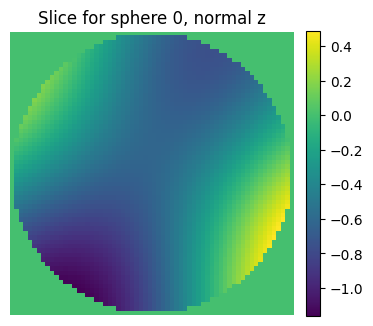

In [3]:
normal_z = torch.tensor([0.0, 0.0, 1.0], device=device)
first_index = torch.tensor([0], device=device)
sample_slice = field.slice(normal_z, mask=first_index, grid_resolution=grid_resolution, flatten=True)

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(sample_slice[0].cpu().numpy(), cmap="viridis", origin="lower")
ax.set_title("Slice for sphere 0, normal z")
ax.axis("off")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.show()

## Ray generation and validation
We re-use the random ray generator and intersection checks from `compute_slices.ipynb`, targeting the cube $[-1, 1]^3$ encompassing the harmonic grid.

In [4]:
def generate_intersecting_rays(k: int, device=None, dtype=torch.float32):
    """Generate k random rays that intersect the cube [-1, 1]^3."""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    rays_origins = []
    rays_directions = []

    k1 = int(0.3 * k)
    if k1 > 0:
        r0_inside = torch.rand(k1, 3, device=device, dtype=dtype) * 2 - 1
        d_inside = torch.randn(k1, 3, device=device, dtype=dtype)
        d_inside = d_inside / torch.norm(d_inside, dim=1, keepdim=True)
        rays_origins.append(r0_inside)
        rays_directions.append(d_inside)

    k2 = int(0.4 * k)
    if k2 > 0:
        face_origins = []
        face_directions = []
        for _ in range(k2):
            face = torch.randint(0, 6, (1,), device=device).item()
            axis = face // 2
            sign = 1 if face % 2 == 0 else -1
            r0_face = torch.rand(3, device=device, dtype=dtype) * 2 - 1
            r0_face[axis] = sign
            center = torch.zeros(3, device=device, dtype=dtype)
            to_center = center - r0_face
            random_dir = torch.randn(3, device=device, dtype=dtype) * 0.5
            d_face = to_center + random_dir
            d_face = d_face / torch.norm(d_face)
            face_origins.append(r0_face)
            face_directions.append(d_face)
        if face_origins:
            rays_origins.append(torch.stack(face_origins))
            rays_directions.append(torch.stack(face_directions))

    k3 = k - k1 - k2
    if k3 > 0:
        r0_outside = torch.randn(k3, 3, device=device, dtype=dtype) * 3
        mask = (r0_outside.abs() <= 1).all(dim=1)
        while mask.any():
            new_origins = torch.randn(mask.sum(), 3, device=device, dtype=dtype) * 4
            r0_outside[mask] = new_origins
            mask = (r0_outside.abs() <= 1).all(dim=1)
        center = torch.zeros(3, device=device, dtype=dtype)
        to_center = center - r0_outside
        random_component = torch.randn(k3, 3, device=device, dtype=dtype) * 0.3
        d_outside = to_center + random_component
        d_outside = d_outside / torch.norm(d_outside, dim=1, keepdim=True)
        rays_origins.append(r0_outside)
        rays_directions.append(d_outside)

    r0 = torch.cat(rays_origins, dim=0)
    d = torch.cat(rays_directions, dim=0)
    perm = torch.randperm(k, device=device)
    return r0[perm], d[perm]


def verify_ray_intersection(r0, d, box_min=-1.0, box_max=1.0):
    """Return masks and entry/exit parameters for rays intersecting [-1,1]^3."""
    k = r0.shape[0]
    device = r0.device
    dtype = r0.dtype

    bounds_min = torch.tensor([box_min, box_min, box_min], device=device, dtype=dtype)
    bounds_max = torch.tensor([box_max, box_max, box_max], device=device, dtype=dtype)

    t_entries = []
    t_exits = []
    for axis in range(3):
        parallel_mask = d[:, axis].abs() < 1e-6
        t1 = torch.full((k,), float("inf"), device=device, dtype=dtype)
        t2 = torch.full((k,), float("-inf"), device=device, dtype=dtype)
        non_parallel = ~parallel_mask
        if non_parallel.any():
            t1[non_parallel] = (bounds_min[axis] - r0[non_parallel, axis]) / d[non_parallel, axis]
            t2[non_parallel] = (bounds_max[axis] - r0[non_parallel, axis]) / d[non_parallel, axis]
        if parallel_mask.any():
            inside = (r0[parallel_mask, axis] >= bounds_min[axis]) & (r0[parallel_mask, axis] <= bounds_max[axis])
            t1[parallel_mask] = torch.where(inside, torch.tensor(float("-inf"), device=device, dtype=dtype), torch.tensor(float("inf"), device=device, dtype=dtype))
            t2[parallel_mask] = torch.where(inside, torch.tensor(float("inf"), device=device, dtype=dtype), torch.tensor(float("-inf"), device=device, dtype=dtype))
        t_entries.append(torch.min(t1, t2))
        t_exits.append(torch.max(t1, t2))

    t_entry = torch.stack(t_entries, dim=1).max(dim=1)[0]
    t_exit = torch.stack(t_exits, dim=1).min(dim=1)[0]
    intersects = t_entry <= t_exit
    t_entry = torch.where(intersects, t_entry, torch.tensor(float("nan"), device=device, dtype=dtype))
    t_exit = torch.where(intersects, t_exit, torch.tensor(float("nan"), device=device, dtype=dtype))
    return intersects, t_entry, t_exit

In [5]:
N_rays = 24
r0, ray_directions = generate_intersecting_rays(N_rays, device=device)
intersects, t_entry, t_exit = verify_ray_intersection(r0, ray_directions)

print(f"Generated {N_rays} rays")
print(f"Intersections: {intersects.float().mean():.3f} succeed")
print(f"Ray origins range: [{r0.min():.2f}, {r0.max():.2f}]")
print(f"Directions normalized: {torch.allclose(torch.norm(ray_directions, dim=1), torch.ones(N_rays, device=device), rtol=1e-5)}")

Generated 24 rays
Intersections: 1.000 succeed
Ray origins range: [-7.24, 4.45]
Directions normalized: True


### Visualizing the ray set
A quick 3D plot helps confirm that the generated rays cover the cube.

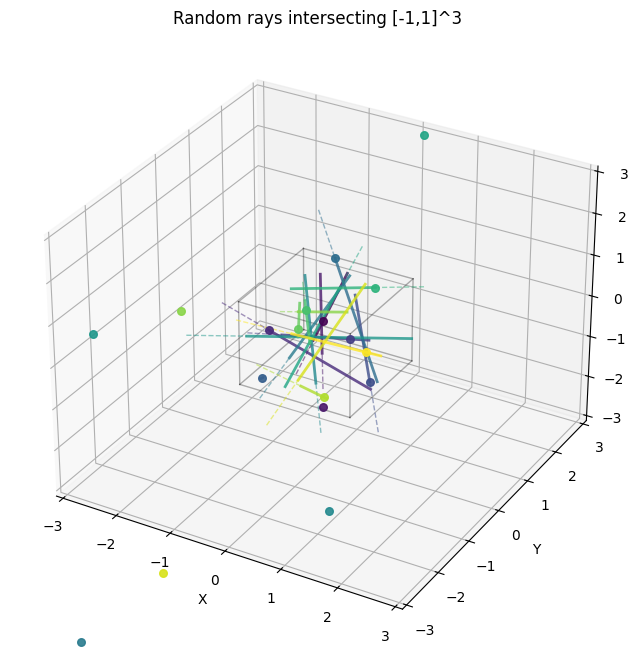

In [6]:
def visualize_rays_3d(r0, d, t_entry, t_exit, num_rays=20):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    cube_edges = [
        [[-1,-1,-1], [1,-1,-1]], [[-1,-1,-1], [-1,1,-1]],
        [[1,-1,-1], [1,1,-1]], [[-1,1,-1], [1,1,-1]],
        [[-1,-1,1], [1,-1,1]], [[-1,-1,1], [-1,1,1]],
        [[1,-1,1], [1,1,1]], [[-1,1,1], [1,1,1]],
        [[-1,-1,-1], [-1,-1,1]], [[1,-1,-1], [1,-1,1]],
        [[-1,1,-1], [-1,1,1]], [[1,1,-1], [1,1,1]]
    ]
    for edge in cube_edges:
        edge = torch.tensor(edge)
        ax.plot3D(edge[:,0], edge[:,1], edge[:,2], 'k-', alpha=0.3, linewidth=1)

    indices = torch.randperm(r0.shape[0])[:num_rays]
    colors = plt.cm.viridis(np.linspace(0, 1, len(indices)))
    for color, idx in zip(colors, indices):
        r0_i = r0[idx].cpu().numpy()
        d_i = d[idx].cpu().numpy()
        t_entry_i = t_entry[idx].cpu().numpy()
        t_exit_i = t_exit[idx].cpu().numpy()
        if np.isnan(t_entry_i) or np.isnan(t_exit_i):
            continue
        p_entry = r0_i + t_entry_i * d_i
        p_exit = r0_i + t_exit_i * d_i
        ax.plot3D([p_entry[0], p_exit[0]], [p_entry[1], p_exit[1]], [p_entry[2], p_exit[2]], color=color, linewidth=2, alpha=0.8)
        ax.scatter(*r0_i, color=color, s=30, alpha=0.9)
        t_extend = max(-3, t_entry_i - 1)
        p_extend = r0_i + t_extend * d_i
        ax.plot3D([p_extend[0], p_entry[0]], [p_extend[1], p_entry[1]], [p_extend[2], p_entry[2]], color=color, linestyle='--', linewidth=1, alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Random rays intersecting [-1,1]^3')
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])
    plt.show()

visualize_rays_3d(r0, ray_directions, t_entry, t_exit, num_rays=18)

## Ray sampling
We sample $K$ points along each ray within the $[-1,1]^3$ bounds and convert them to grid coordinates, exactly as in the voxel-based workflow.

In [7]:
def batched_sample_ray_points(r0: torch.Tensor, d: torch.Tensor, K=50, vol_bounds=(-1, 1)):
    """Batch version of the ray sampler returning normalized grid_sample coordinates."""
    k = r0.shape[0]
    device = r0.device
    dtype = r0.dtype
    vol_min, vol_max = vol_bounds

    d = d / torch.norm(d, dim=1, keepdim=True)

    bounds_min = torch.tensor([vol_min, vol_min, vol_min], device=device, dtype=dtype)
    bounds_max = torch.tensor([vol_max, vol_max, vol_max], device=device, dtype=dtype)

    tmin = torch.full((k,), -1e9, device=device, dtype=dtype)
    tmax = torch.full((k,), 1e9, device=device, dtype=dtype)

    for axis in range(3):
        lo, hi = bounds_min[axis], bounds_max[axis]
        parallel_mask = d[:, axis].abs() < 1e-6
        t1 = torch.full((k,), float("inf"), device=device, dtype=dtype)
        t2 = torch.full((k,), float("-inf"), device=device, dtype=dtype)
        non_parallel = ~parallel_mask
        if non_parallel.any():
            t1[non_parallel] = (lo - r0[non_parallel, axis]) / d[non_parallel, axis]
            t2[non_parallel] = (hi - r0[non_parallel, axis]) / d[non_parallel, axis]
        if parallel_mask.any():
            inside = (r0[parallel_mask, axis] >= lo) & (r0[parallel_mask, axis] <= hi)
            t1[parallel_mask] = torch.where(inside, torch.tensor(float("-inf"), device=device, dtype=dtype), torch.tensor(float("inf"), device=device, dtype=dtype))
            t2[parallel_mask] = torch.where(inside, torch.tensor(float("inf"), device=device, dtype=dtype), torch.tensor(float("-inf"), device=device, dtype=dtype))
        t_entry_axis = torch.min(t1, t2)
        t_exit_axis = torch.max(t1, t2)
        tmin = torch.max(tmin, t_entry_axis)
        tmax = torch.min(tmax, t_exit_axis)

    valid_rays = tmin <= tmax
    tmin = torch.where(valid_rays, tmin, torch.tensor(0.0, device=device, dtype=dtype))
    tmax = torch.where(valid_rays, tmax, torch.tensor(0.0, device=device, dtype=dtype))

    t_vals = torch.linspace(0, 1, K, device=device, dtype=dtype)[None, :].expand(k, K)
    t_samples = tmin[:, None] + t_vals * (tmax[:, None] - tmin[:, None])
    pts = r0[:, None, :] + t_samples[:, :, None] * d[:, None, :]

    normalized_pts = 2 * (pts - vol_min) / (vol_max - vol_min) - 1
    invalid_mask = ~valid_rays[:, None, None]
    normalized_pts = torch.where(invalid_mask, torch.tensor(0.0, device=device, dtype=dtype), normalized_pts)
    return normalized_pts


def sample_ray_points(r0: torch.Tensor, d: torch.Tensor, K=50, vol_bounds=(-1, 1)):
    """Single-ray helper mirroring batched_sample_ray_points."""
    d = d / torch.norm(d)
    vol_min, vol_max = vol_bounds
    bounds_min = torch.tensor([vol_min, vol_min, vol_min], dtype=r0.dtype)
    bounds_max = torch.tensor([vol_max, vol_max, vol_max], dtype=r0.dtype)

    tmin, tmax = -1e9, 1e9
    for axis in range(3):
        lo, hi = bounds_min[axis], bounds_max[axis]
        if torch.abs(d[axis]) < 1e-6:
            if r0[axis] < lo or r0[axis] > hi:
                return torch.zeros(K, 3)
            continue
        t1 = (lo - r0[axis]) / d[axis]
        t2 = (hi - r0[axis]) / d[axis]
        tmin = max(tmin, min(t1, t2))
        tmax = min(tmax, max(t1, t2))

    if tmin > tmax:
        return torch.zeros(K, 3)

    ts = torch.linspace(tmin, tmax, K, dtype=r0.dtype)
    pts = r0[None, :] + ts[:, None] * d[None, :]
    normalized_pts = 2 * (pts - vol_min) / (vol_max - vol_min) - 1
    return normalized_pts

In [8]:
K = 30
sampled_ray_points = batched_sample_ray_points(r0, ray_directions, K=K)

print(f"Sampled ray points shape: {sampled_ray_points.shape}")
print(f"Value range: [{sampled_ray_points.min():.3f}, {sampled_ray_points.max():.3f}]")

non_zero_samples = (sampled_ray_points.abs().sum(dim=-1) > 0).float()
success_rate = non_zero_samples.sum(dim=1) / K
print(f"Average success rate: {success_rate.mean():.3f}")
print(f"Rays with >90% valid samples: {(success_rate > 0.9).float().mean():.3f}")

for i in range(min(3, r0.shape[0])):
    single_sample = sample_ray_points(r0[i].cpu(), ray_directions[i].cpu(), K=K)
    batched_sample = sampled_ray_points[i].cpu()
    single_nonzero = (single_sample.abs().sum(dim=-1) > 0).float().sum()
    batched_nonzero = (batched_sample.abs().sum(dim=-1) > 0).float().sum()
    print(f"Ray {i}: single {single_nonzero.item():.0f}/{K}, batched {batched_nonzero.item():.0f}/{K}")

Sampled ray points shape: torch.Size([24, 30, 3])
Value range: [-1.000, 1.000]
Average success rate: 1.000
Rays with >90% valid samples: 1.000
Ray 0: single 30/30, batched 30/30
Ray 1: single 30/30, batched 30/30
Ray 2: single 30/30, batched 30/30


## Trilinear interpolation coefficients
We compute the 8-corner indices and weights for every sampled point, mapping points in $[-1,1]^3$ onto the 10×10×10 harmonic grid.

In [9]:
def compute_trilinear_interpolation_coefficients(sample_points, grid_shape):
    N_rays, K, _ = sample_points.shape
    D, H, W = grid_shape
    device = sample_points.device
    dtype = sample_points.dtype

    grid_coords = (sample_points + 1) / 2
    grid_coords *= torch.tensor([D - 1, H - 1, W - 1], device=device, dtype=dtype)

    lower_corners = torch.floor(grid_coords).long()
    lower_corners[..., 0] = lower_corners[..., 0].clamp(0, D - 2)
    lower_corners[..., 1] = lower_corners[..., 1].clamp(0, H - 2)
    lower_corners[..., 2] = lower_corners[..., 2].clamp(0, W - 2)

    fractions = (grid_coords - lower_corners.float()).clamp(0.0, 1.0)

    corner_offsets = torch.tensor([
        [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1],
        [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1],
    ], dtype=torch.long, device=device)

    corner_indices = lower_corners.unsqueeze(2) + corner_offsets.unsqueeze(0).unsqueeze(0)

    fx = fractions[..., 0:1]
    fy = fractions[..., 1:2]
    fz = fractions[..., 2:3]
    one_minus_fx = 1 - fx
    one_minus_fy = 1 - fy
    one_minus_fz = 1 - fz

    coeff_list = []
    for idx in range(8):
        i, j, k = corner_offsets[idx]
        coeff_x = fx if i == 1 else one_minus_fx
        coeff_y = fy if j == 1 else one_minus_fy
        coeff_z = fz if k == 1 else one_minus_fz
        coeff_list.append((coeff_x * coeff_y * coeff_z).squeeze(-1))

    coefficients = torch.stack(coeff_list, dim=2)

    valid_mask = (
        (lower_corners[..., 0] >= 0) & (lower_corners[..., 0] <= D - 2) &
        (lower_corners[..., 1] >= 0) & (lower_corners[..., 1] <= H - 2) &
        (lower_corners[..., 2] >= 0) & (lower_corners[..., 2] <= W - 2)
    )

    return corner_indices, coefficients, valid_mask


def verify_trilinear_interpolation(sample_points, corner_indices, coefficients, valid_mask, grid_shape):
    D, H, W = grid_shape
    device = sample_points.device
    dtype = sample_points.dtype

    corner_coords_grid = corner_indices.float()
    grid_to_norm = 2.0 / torch.tensor([D - 1, H - 1, W - 1], device=device, dtype=dtype)
    corner_coords_norm = corner_coords_grid * grid_to_norm - 1

    reconstructed_points = torch.sum(coefficients.unsqueeze(-1) * corner_coords_norm, dim=2)
    reconstruction_error = torch.abs(reconstructed_points - sample_points)
    valid_errors = reconstruction_error[valid_mask]

    coeff_sums = coefficients.sum(dim=-1)
    coeff_sum_error = torch.abs(coeff_sums[valid_mask] - 1.0).max().item() if valid_mask.any() else float('nan')

    print(f"Valid point ratio: {valid_mask.float().mean():.3f}")
    if valid_mask.any():
        print(f"Max coefficient sum error: {coeff_sum_error:.2e}")
        print(f"Max point reconstruction error: {valid_errors.max():.2e}")

    return reconstruction_error

In [10]:
corner_indices, coefficients, valid_mask = compute_trilinear_interpolation_coefficients(
    sampled_ray_points, grid_dims
)

print(f"corner_indices shape: {corner_indices.shape}")
print(f"coefficients shape: {coefficients.shape}")
print(f"valid mask shape: {valid_mask.shape}")

reconstruction_error = verify_trilinear_interpolation(
    sampled_ray_points, corner_indices, coefficients, valid_mask, grid_dims
)

corner_indices shape: torch.Size([24, 30, 8, 3])
coefficients shape: torch.Size([24, 30, 8])
valid mask shape: torch.Size([24, 30])
Valid point ratio: 1.000
Max coefficient sum error: 1.19e-07
Max point reconstruction error: 4.77e-07


## Harmonic-field interpolation along rays
We adapt the advanced interpolation routines so they accept a `SphericalBesselHarmonicField` instance instead of a voxel tensor. The only change is that corner data are obtained via the field's `slice` method.

In [11]:
import torch.nn.functional as F

def _flatten_indices(indices_3d: torch.Tensor, dims: tuple[int, int, int]) -> torch.Tensor:
    strides = (dims[1] * dims[2], dims[2], 1)
    return (
        indices_3d[..., 0] * strides[0]
        + indices_3d[..., 1] * strides[1]
        + indices_3d[..., 2] * strides[2]
    )


def corrected_advanced_ray_interpolation_field(
    field: SphericalBesselHarmonicField,
    corner_indices: torch.Tensor,
    coefficients: torch.Tensor,
    valid_mask: torch.Tensor,
    ray_directions: torch.Tensor,
    grid_resolution: int,
    extent: float | None = None,
):
    """Sequential harmonic-field interpolation mirroring the voxel workflow."""
    dims = field.dims
    N_rays, K, _, _ = corner_indices.shape
    device = field.device
    dtype = field.dtype

    plane_size = grid_resolution * grid_resolution
    results = torch.zeros(N_rays, K, plane_size, device=device, dtype=dtype)

    ray_dirs = F.normalize(ray_directions.to(device=device, dtype=dtype), dim=-1)

    for ray_idx in range(N_rays):
        ray_dir = ray_dirs[ray_idx]
        ray_valid = valid_mask[ray_idx]
        ray_coeffs = coefficients[ray_idx].to(device=device, dtype=dtype)
        for sample_idx in range(K):
            if not ray_valid[sample_idx]:
                continue
            sample_corners = corner_indices[ray_idx, sample_idx].to(device=device)
            linear_indices = _flatten_indices(sample_corners, dims)
            corner_slices = field.slice(
                ray_dir,
                mask=linear_indices.to(device=device),
                grid_resolution=grid_resolution,
                extent=extent,
                flatten=True,
            )
            corner_slices_flat = corner_slices.view(corner_slices.shape[0], plane_size)
            sample_coeffs = ray_coeffs[sample_idx].unsqueeze(1)
            interpolated = torch.sum(sample_coeffs * corner_slices_flat, dim=0)
            results[ray_idx, sample_idx] = interpolated

    return results

In [12]:
def parallel_corrected_advanced_interpolation_field(
    field: SphericalBesselHarmonicField,
    corner_indices: torch.Tensor,
    coefficients: torch.Tensor,
    valid_mask: torch.Tensor,
    ray_directions: torch.Tensor,
    grid_resolution: int,
    extent: float | None = None,
):
    """Parallel harmonic-field interpolation that batches corner slices per ray."""
    dims = field.dims
    N_rays, K, _, _ = corner_indices.shape
    device = field.device
    dtype = field.dtype

    plane_size = grid_resolution * grid_resolution
    results = torch.zeros(N_rays, K, plane_size, device=device, dtype=dtype)
    ray_dirs = F.normalize(ray_directions.to(device=device, dtype=dtype), dim=-1)

    for ray_idx in range(N_rays):
        ray_dir = ray_dirs[ray_idx]
        ray_valid = valid_mask[ray_idx]
        valid_indices = ray_valid.nonzero(as_tuple=False).squeeze(-1)
        if valid_indices.numel() == 0:
            continue

        ray_corner_indices = corner_indices[ray_idx, valid_indices].to(device=device)
        flattened = ray_corner_indices.view(-1, 3)
        unique_corners, inverse = torch.unique(flattened, dim=0, return_inverse=True)
        linear_unique = _flatten_indices(unique_corners, dims)

        unique_slices = field.slice(
            ray_dir,
            mask=linear_unique,
            grid_resolution=grid_resolution,
            extent=extent,
            flatten=True,
        )
        unique_slices_flat = unique_slices.view(unique_slices.shape[0], plane_size)
        inverse_map = inverse.view(-1, 8)

        ray_coeffs = coefficients[ray_idx].to(device=device, dtype=dtype)
        for local_idx, sample_idx in enumerate(valid_indices):
            sample_coeffs = ray_coeffs[sample_idx].unsqueeze(1)
            sample_corner_ids = inverse_map[local_idx]
            sample_slices = unique_slices_flat[sample_corner_ids]
            interpolated = torch.sum(sample_coeffs * sample_slices, dim=0)
            results[ray_idx, sample_idx] = interpolated

    return results

In [13]:
sequential_results = corrected_advanced_ray_interpolation_field(
    field,
    corner_indices,
    coefficients,
    valid_mask,
    ray_directions,
    grid_resolution=grid_resolution,
)

parallel_results = parallel_corrected_advanced_interpolation_field(
    field,
    corner_indices,
    coefficients,
    valid_mask,
    ray_directions,
    grid_resolution=grid_resolution,
)

print(f"Sequential output shape: {sequential_results.shape}")
print(f"Parallel output shape: {parallel_results.shape}")
print(f"Value range (sequential): [{sequential_results.min():.4f}, {sequential_results.max():.4f}]")
print(f"Value range (parallel):   [{parallel_results.min():.4f}, {parallel_results.max():.4f}]")

max_diff = torch.max(torch.abs(sequential_results - parallel_results))
print(f"Max absolute difference between methods: {max_diff:.3e}")

/Users/lfbarba/GitHub/smartTT/pyTT/fields.py:557: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Cross.cpp:67.)
  k = torch.cross(ez, n)  # rotation axis (unnormalized)


Sequential output shape: torch.Size([24, 30, 4096])
Parallel output shape: torch.Size([24, 30, 4096])
Value range (sequential): [-1.0988, 1.2864]
Value range (parallel):   [-1.0988, 1.2864]
Max absolute difference between methods: 0.000e+00


### Visualising interpolated slices
We plot a few interpolated slices per ray to inspect the harmonic-field reconstruction.

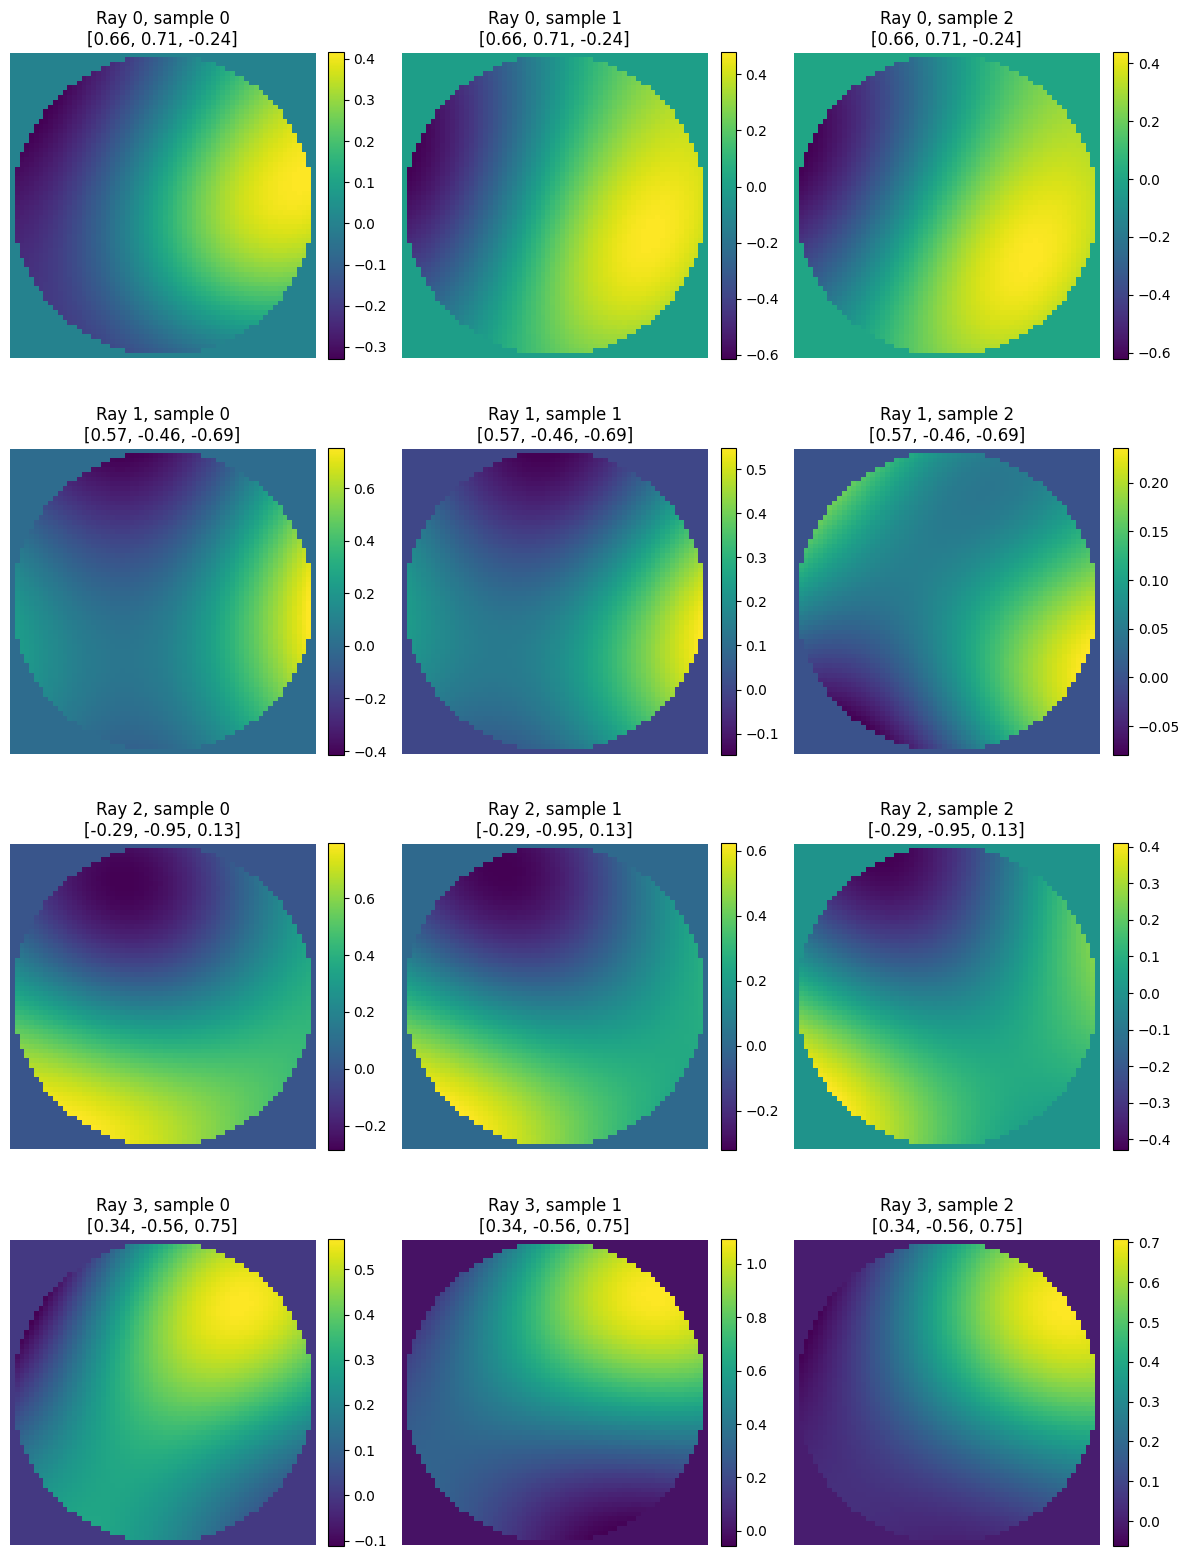

In [14]:
def visualize_harmonic_results(results, ray_directions, N_slice, num_rays=4, num_samples=3):
    N_rays, K, _ = results.shape
    num_rays = min(num_rays, N_rays)
    num_samples = min(num_samples, K)
    fig, axes = plt.subplots(num_rays, num_samples, figsize=(4 * num_samples, 4 * num_rays))
    if num_rays == 1:
        axes = axes.reshape(1, -1)

    for ray_idx in range(num_rays):
        for sample_idx in range(num_samples):
            ax = axes[ray_idx, sample_idx] if num_rays > 1 else axes[sample_idx]
            slice_data = results[ray_idx, sample_idx].view(N_slice, N_slice).cpu().numpy()
            im = ax.imshow(slice_data, cmap='viridis', origin='lower')
            ax.axis('off')
            ray_dir = ray_directions[ray_idx].cpu().numpy()
            ax.set_title(f"Ray {ray_idx}, sample {sample_idx}\n[{ray_dir[0]:.2f}, {ray_dir[1]:.2f}, {ray_dir[2]:.2f}]")
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

visualize_harmonic_results(parallel_results, ray_directions, grid_resolution)

In [15]:
torch.allclose(sequential_results, parallel_results, atol=1e-5)

True